In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
sys.path.append( '../src/' )

from ml.preprocessing import *

# Data Preprocessing

## Reading excel sheets

In [2]:
%%time
sheets = [ 'Friday 15 May', 'Sunday 24 May', 'Monday 25 May', 'Tuesday 26 May', 
          'Wednesday 27 May', 'Thursday 28 May', 'Friday 29 May', 'Sunday May 31', 
          'Monday June 1', 'Thursday June 4', 'Friday June 5' ]

df = read_sheets( '../datasets/dataset-residential.xlsx', sheets )
df

CPU times: user 46.1 s, sys: 556 ms, total: 46.7 s
Wall time: 47.1 s


,pre,alt,hum,tem,ven,occ
date,,,,,,
2020-05-14 21:08:39,94270.77,604.60,54.49,30.99,1.0,L
2020-05-14 21:08:40,94268.36,604.81,54.46,30.99,1.0,L
2020-05-14 21:08:41,94266.11,605.01,54.46,30.99,1.0,L
2020-05-14 21:08:42,94268.52,604.80,54.49,30.99,1.0,L
2020-05-14 21:08:43,94269.70,604.69,54.50,30.99,1.0,L
...,...,...,...,...,...,...
2020-06-05 10:01:23,94731.69,563.99,61.02,30.35,NaN,NaN
2020-06-05 10:01:24,94732.08,563.96,61.01,30.35,NaN,NaN
2020-06-05 10:01:25,94729.84,564.25,61.01,30.35,NaN,NaN


## Removing null values

In [3]:
print( 'Legnth: ', len( df ) )
print( 'Null values:' )
len( df ) - df.count()

Legnth:  353712
Null values:


pre        0
alt        0
hum       97
tem        0
ven    57819
occ    57819
dtype: int64

In [4]:
df = df.dropna( axis = 0, subset = [ 'occ', 'hum' ], thresh = 2 )

In [5]:
print( 'Legnth: ', len( df ) )
print( 'Null values:' )
len( df ) - df.count()

Legnth:  295823
Null values:


pre    0
alt    0
hum    0
tem    0
ven    0
occ    0
dtype: int64

## Visualization

In [6]:
# plot_env_vars( df.index.astype( str ), df[ 'tem' ], df[ 'hum' ], df[ 'occ' ] )
# plot_single( df.index.astype( str ), df[ 'pre' ], 'Pressure' )

# Features Selection

In [7]:
from ml.feature_selection import *
from ml.generation import *

## Recursive Feature Elimination 

In [8]:
x_train, x_test, y_train, y_test = split_data( df, test_size = 0.20 )
x_train, x_test = standardize( x_train, x_test )
selected_rfe = select_k_rfe( x_train, y_train, df.columns[ : -1 ], 1 )
selected_rfe

,rank,selected
hum,1,1
pre,2,0
tem,3,0
ven,4,0
alt,5,0


## 3.2 Selecting K-best

In [9]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision = 2)
selected_kbest = select_k_best( x_train, y_train, df.columns[ : -1 ], 3 )
selected_kbest

,score,p-value
tem,"42,166.13",0.00
ven,"41,196.57",0.00
hum,"22,034.33",0.00
alt,"11,741.74",0.00
pre,"11,732.62",0.00


## 3.3 Feature Correlation

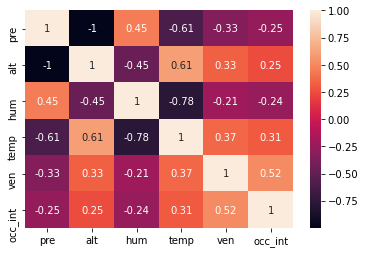

In [10]:
occ_int = df[ 'occ' ].replace( { 'E': 0, 'L':0, 'M':2, 'H':1 } )
temp = pd.concat( [ df, occ_int ], axis = 1 ).dropna( thresh = 2 )
temp.columns = [ 'pre', 'alt', 'hum', 'temp', 'ven', 'occ', 'occ_int' ]

sns.heatmap( temp.corr(), annot = True )

# Datasets Generation

In [11]:
from ml.generation import *
import enum

class DF( enum.Enum ):
    _OR = 0
    _10SEC = 1
    _1MIN = 2
    _5MIN = 3

AGG = [ 'mean' ]
dfs = { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }
grids = { 
    'svc': { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'knn': { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'dt': { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None } }

## Different resolutions generation

### 10 sec. avg.

In [12]:
dfs[ DF._10SEC ] = df_10sec_avg( df.reset_index( drop = False ), AGG ).set_index( 'date' )

### 1 minute samples

In [13]:
dfs[ DF._1MIN ] = df_1min_samples( df )

### 5 minutes samples

In [14]:
dfs[ DF._5MIN ] = df_5min_samples( df )

## Data splitting, standarization and balancing

In [15]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._OR: 1, 
    DF._10SEC: 1, 
    DF._1MIN: 1, 
    DF._5MIN: 1 
}

for k, d in dfs.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    dfs[ k ] = temp

Before balancing: DF._10SEC Counter({'L': 16223, 'E': 4084, 'M': 2826, 'H': 536})
After balancing: DF._10SEC Counter({'M': 16256, 'L': 16223, 'H': 16216, 'E': 16200})

Before balancing: DF._1MIN Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN Counter({'E': 2737, 'H': 2732, 'L': 2730, 'M': 2724})

Before balancing: DF._5MIN Counter({'L': 553, 'E': 136, 'M': 96, 'H': 19})
After balancing: DF._5MIN Counter({'M': 558, 'E': 556, 'L': 553, 'H': 551})



# Classification

In [16]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from ml.classification import *


params_svc = [ { 
    'C': [ .1, 1, 10,  ], 
    'kernel': [ 'linear', 'poly' ] 
}, { 
    'C': [ .1, 1, 10 ], 
    'kernel': [ 'rbf' ],
    'gamma': [ 10, 1, 0.1 ]
} ]

## Regular

In [19]:
%%time
for k, df in dfs.items():
    if( k != DF._10SEC and k != DF._1MIN ):
        print( 'Dataset ', k, len( df ) )
        train_and_test( 
                SVC(), params_svc, 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN 4
Best params:  {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Training Accuracy 0.964389955566426
Test Accuracy:  0.8955223880597015
CPU times: user 30.1 s, sys: 155 ms, total: 30.2 s
Wall time: 30.5 s


## PCA

In [20]:
%%time
for k, df in dfs.items():
    if( k != DF._10SEC and k != DF._1MIN ): 
        print( 'Dataset ', k )
        grids[ 'svc' ][ k ] = train_and_test( 
                make_pipeline( PCA( .95 ), SVC() ), 
                prefix_params( params_svc, 'svc' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN
Best params:  {'svc__C': 10, 'svc__gamma': 10, 'svc__kernel': 'rbf'}
Training Accuracy 0.9528973543679428
Test Accuracy:  0.8805970149253731
CPU times: user 3min 52s, sys: 2.69 s, total: 3min 55s
Wall time: 41.8 s


# Evaluation

In [21]:
from ml.evaluation import *

## Learning Curves

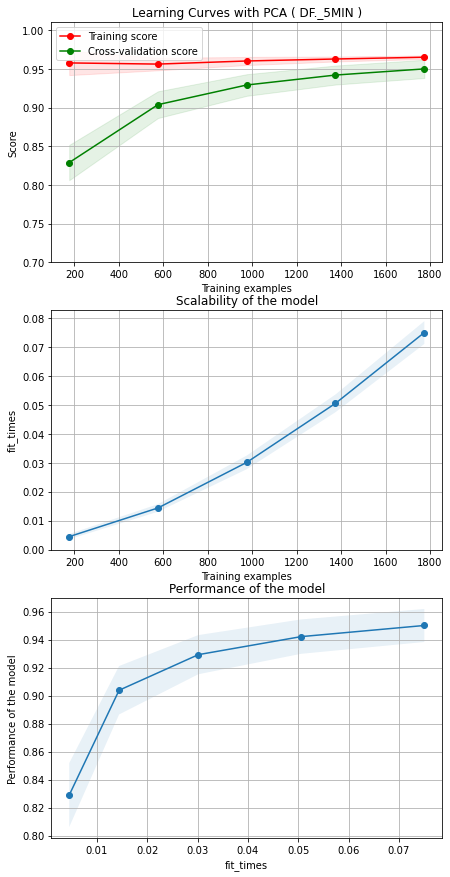

In [22]:
temp = [ item for item in dfs.items() if item[ 0 ] not in [ DF._10SEC, DF._1MIN ] ]
plot_learning_curves( temp, grids[ 'svc' ], 'SVM' )